## Identification of EMT Clusters

In [1]:
import scanpy as sc  # For single-cell RNA-seq data analysis.
import scvi  # For probabilistic modeling of single-cell data.
import pandas as pd # For data manipulation and analysis.
import numpy as np # For numerical computing.
import scipy.sparse # For sparse matrix operations.
import gseapy as gp # For gene set enrichment analysis.
import seaborn as sns # For data visualization.
import matplotlib.pyplot as plt # For plotting.

In [2]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"


In [3]:
# Load the AnnData object from the specified h5ad file
adata = sc.read_h5ad(f'{base_data_path}/infer_cnv_completed.h5ad')

# Display the loaded AnnData object
adata


AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type', 'cnv_leiden', 'cnv_score'
    var: 'n_cells', 'chromosome', 'start', 'end'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [4]:
# Load the pre-trained SCVI model, linking it to the provided AnnData object
model = scvi.model.SCVI.load(f'{base_data_path}/model.model', adata)


INFO     File /Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data/model.model/model.pt already downloaded          


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = tor

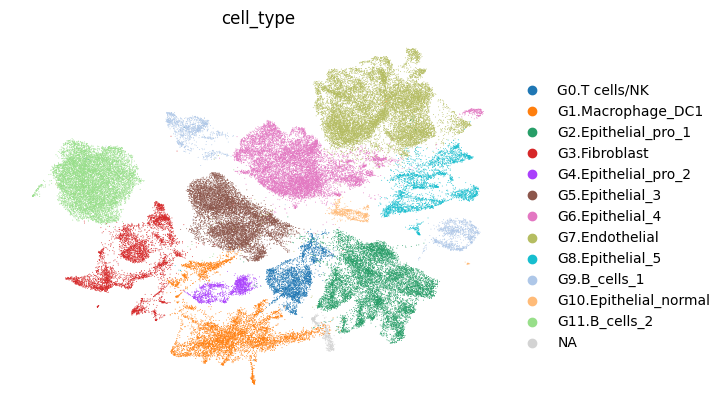

In [5]:
# Plot a UMAP visualization for the AnnData object, coloring points by cell type
# `frameon=False` removes the plot frame for a cleaner look
# The data layer "scvi_normalized" is specified to use normalized values from the SCVI model
sc.pl.umap(adata, color=['cell_type'], frameon=False, layer="scvi_normalized")


In [6]:
# Count the occurrences of each cell type in the AnnData object
adata.obs["cell_type"].value_counts()


cell_type
G7.Endothelial           13669
G6.Epithelial_4          10650
G11.B_cells_2             9620
G2.Epithelial_pro_1       9422
G5.Epithelial_3           8566
G1.Macrophage_DC1         6331
G3.Fibroblast             4803
G8.Epithelial_5           3101
G0.T cells/NK             2906
G9.B_cells_1              2112
G4.Epithelial_pro_2       1363
G10.Epithelial_normal      607
Name: count, dtype: int64

## Subset Analysis of Epithelial Cells with High vs. Low uPAR Expression

In [7]:
# Define the list of epithelial cell clusters to subset based on uPAR expression
epithelial_clusters = ['G2.Epithelial_pro_1', 'G4.Epithelial_pro_2', 
                       'G5.Epithelial_3', 'G6.Epithelial_4', 'G8.Epithelial_5']


In [8]:
# Subset the AnnData object to include only cells from the specified epithelial clusters
epithelial_cells = adata[adata.obs['cell_type'].isin(epithelial_clusters)]


In [9]:
# Extract the normalized expression of the PLAUR gene from the SCVI-normalized layer in the epithelial cell subset
plaured_normalized_expr = epithelial_cells[:, 'PLAUR'].layers['scvi_normalized']


In [10]:
# Check if the PLAUR expression data is in a sparse format and convert it to a dense array if necessary
if scipy.sparse.issparse(plaured_normalized_expr):
    plaured_normalized_expr = plaured_normalized_expr.toarray().flatten()  # Convert sparse matrix to dense array and flatten
else:
    plaured_normalized_expr = plaured_normalized_expr.flatten()  # Flatten if already dense


In [11]:
# Calculate the 90th and 10th percentiles of PLAUR expression for high and low expression thresholds
plaured_90th_percentile = np.percentile(plaured_normalized_expr, 90)
plaured_10th_percentile = np.percentile(plaured_normalized_expr, 10)


In [12]:
plaured_90th_percentile , plaured_10th_percentile

(12.44987907409668, 0.6444425702095032)

In [13]:
# Assign cells a PLAUR expression status based on high, low, or intermediate expression levels
# 'PLAUR+' if expression is in the top 90th percentile, 'PLAUR-' if in the bottom 10th, and 'Intermediate' otherwise
plaured_status = np.where(plaured_normalized_expr >= plaured_90th_percentile, 'PLAUR+',
                          np.where(plaured_normalized_expr <= plaured_10th_percentile, 'PLAUR-', 'Intermediate'))


In [14]:
# Create a copy of the epithelial_cells view to allow modification without warnings
epithelial_cells = epithelial_cells.copy()

# Add the PLAUR expression status as a new column in the metadata of the epithelial cells AnnData object
epithelial_cells.obs['PLAUR_Status'] = plaured_status


In [15]:
# Create a DataFrame to organize and analyze PLAUR expression, cell types, and PLAUR status
df = pd.DataFrame({
    'PLAUR_normalized_expr': plaured_normalized_expr,   # Normalized expression values for PLAUR
    'cell_type': epithelial_cells.obs['cell_type'],     # Cell type information from the epithelial cells subset
    'PLAUR_Status': plaured_status                      # PLAUR expression status (PLAUR+, PLAUR-, Intermediate)
})
df.head()  # Display the first few rows of the DataFrame

,PLAUR_normalized_expr,cell_type,PLAUR_Status
AAACCCACATGATGCT-1,1.011938,G2.Epithelial_pro_1,Intermediate
AAACCCAGTGTCCCTT-1,14.802988,G6.Epithelial_4,PLAUR+
AAAGAACAGTACGAGC-1,1.722822,G2.Epithelial_pro_1,Intermediate
AAAGAACCATTGAAGA-1,3.784069,G6.Epithelial_4,Intermediate
AAAGGGCCAATTGAAG-1,0.724520,G2.Epithelial_pro_1,Intermediate


In [16]:
# Print the distribution of PLAUR expression status categories (PLAUR+, PLAUR-, Intermediate) based on quantiles
print("PLAUR Status distribution based on quantiles:")
print(df['PLAUR_Status'].value_counts())


PLAUR Status distribution based on quantiles:
PLAUR_Status
Intermediate    26480
PLAUR+           3311
PLAUR-           3311
Name: count, dtype: int64


In [17]:
# Calculate the percentage of cells with 'PLAUR+' status within each cell type, with observed=True to silence future warnings
percentage_by_cell_type = df.groupby('cell_type', observed=True)['PLAUR_Status'].apply(lambda x: (x == 'PLAUR+').mean() * 100)


# Count the total number of cells for each cell type
total_cells_by_cell_type = df['cell_type'].value_counts()


In [18]:
# Print the calculated percentage of PLAUR+ cells by cell type (using the 90th percentile threshold)
print("\nPercentage of PLAUR+ cells by cell_type (90th percentile):")
print(percentage_by_cell_type)




Percentage of PLAUR+ cells by cell_type (90th percentile):
cell_type
G2.Epithelial_pro_1     0.053067
G4.Epithelial_pro_2     0.000000
G5.Epithelial_3         0.490311
G6.Epithelial_4        23.934272
G8.Epithelial_5        23.057078
Name: PLAUR_Status, dtype: float64


In [19]:

# Print the total number of cells in each cell type group
print("\nTotal number of cells in each cell_type group:")
print(total_cells_by_cell_type)


Total number of cells in each cell_type group:
cell_type
G6.Epithelial_4        10650
G2.Epithelial_pro_1     9422
G5.Epithelial_3         8566
G8.Epithelial_5         3101
G4.Epithelial_pro_2     1363
Name: count, dtype: int64


In [20]:
# Calculate the percentage of cells with 'PLAUR-' status within each cell type
percentage_by_cell_type_neg = df.groupby('cell_type', observed=True)['PLAUR_Status'].apply(lambda x: (x == 'PLAUR-').mean() * 100)


In [21]:
# Print the calculated percentage of PLAUR- cells by cell type (using the 10th percentile threshold)
print("\nPercentage of PLAUR- cells by cell_type (10th percentile):")
print(percentage_by_cell_type_neg)



Percentage of PLAUR- cells by cell_type (10th percentile):
cell_type
G2.Epithelial_pro_1    25.758862
G4.Epithelial_pro_2     0.146735
G5.Epithelial_3         0.011674
G6.Epithelial_4         0.328638
G8.Epithelial_5        27.281522
Name: PLAUR_Status, dtype: float64


In [22]:
# Display the metadata for the epithelial cells subset
epithelial_cells.obs


,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,_scvi_batch,...,leiden,predicted_labels,over_clustering,majority_voting,conf_score,score_sig,cell_type,cnv_leiden,cnv_score,PLAUR_Status
AAACCCACATGATGCT-1,Treated,False,4646,20165.0,1110.0,5.504587,1974.0,9.789239,4646,0,...,2,Fibroblasts,107,Fibroblasts,1.000000,-0.211553,G2.Epithelial_pro_1,6,0.006360,Intermediate
AAACCCAGTGTCCCTT-1,Treated,False,1981,5357.0,288.0,5.376143,411.0,7.672205,1981,0,...,6,Classical monocytes,289,Classical monocytes,0.993037,-0.005591,G6.Epithelial_4,9,0.005086,PLAUR+
AAAGAACAGTACGAGC-1,Treated,False,5287,24639.0,1861.0,7.553066,2842.0,11.534559,5287,0,...,2,Fibroblasts,107,Fibroblasts,1.000000,-0.204163,G2.Epithelial_pro_1,6,0.006360,Intermediate
AAAGAACCATTGAAGA-1,Treated,False,2981,9893.0,1097.0,11.088649,1412.0,14.272718,2981,0,...,6,DC2,64,Alveolar macrophages,0.999820,0.030114,G6.Epithelial_4,10,0.005817,Intermediate
AAAGGGCCAATTGAAG-1,Treated,False,2919,8793.0,863.0,9.814625,596.0,6.778119,2919,0,...,2,Fibroblasts,107,Fibroblasts,1.000000,-0.183153,G2.Epithelial_pro_1,6,0.006360,Intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACCAAGTTCATGC-1,Untreated,False,541,990.0,30.0,3.030303,81.0,8.181818,541,0,...,8,Intermediate macrophages,112,Intermediate macrophages,0.902410,0.119501,G8.Epithelial_5,1,0.005707,PLAUR+
TTTACGTCAGTTAAAG-1,Untreated,False,1401,2831.0,129.0,4.556694,533.0,18.827271,1401,0,...,6,Classical monocytes,259,Classical monocytes,0.999437,-0.119462,G6.Epithelial_4,10,0.005817,Intermediate
TTTAGTCTCTGCCTCA-1,Untreated,False,2775,11739.0,41.0,0.349263,1420.0,12.096431,2775,0,...,6,Macrophages,118,Alveolar macrophages,0.881057,-0.046194,G6.Epithelial_4,0,0.005460,Intermediate
TTTCCTCTCTAGTGAC-1,Untreated,False,585,1562.0,2.0,0.128041,33.0,2.112676,585,0,...,8,Intermediate macrophages,112,Intermediate macrophages,0.904128,-0.008836,G8.Epithelial_5,1,0.005707,PLAUR+


In [23]:
# Identify differentially expressed genes between PLAUR_Status groups using the Wilcoxon rank-sum test
sc.tl.rank_genes_groups(epithelial_cells, groupby='PLAUR_Status', method='wilcoxon')


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


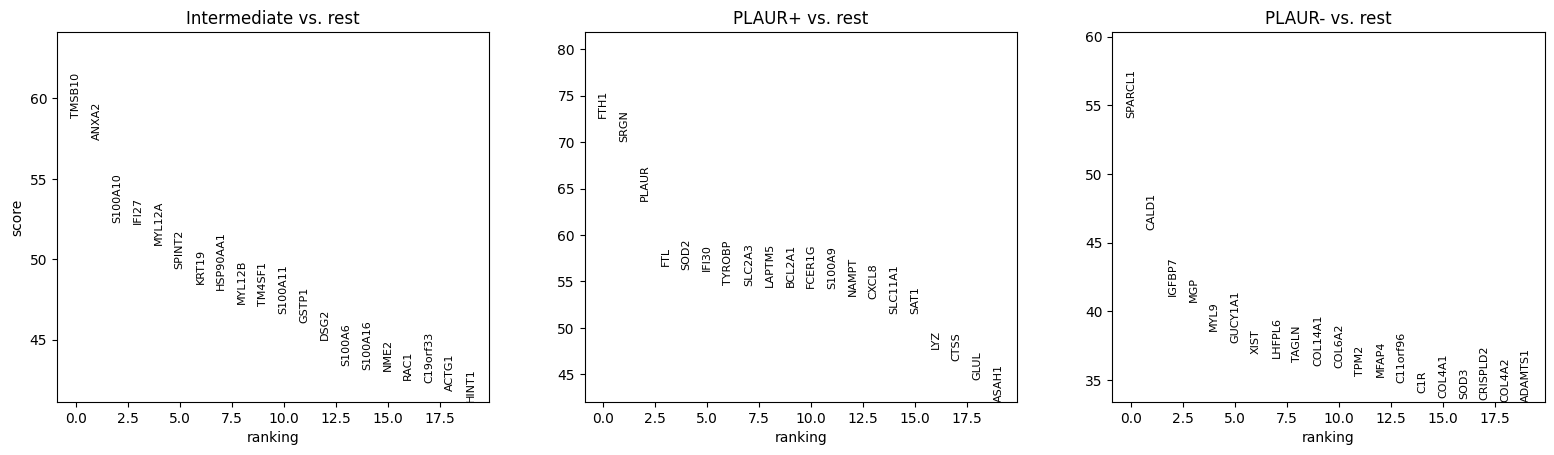

In [24]:
# Plot the top 20 differentially expressed genes for each PLAUR_Status group
sc.pl.rank_genes_groups(epithelial_cells, n_genes=20, sharey=False)

In [25]:
# Retrieve marker genes from the differential expression analysis for all groups in PLAUR_Status
marker_genes = sc.get.rank_genes_groups_df(epithelial_cells, group=None)


In [26]:
# Filter marker genes to identify those upregulated in the PLAUR+ group
# Criteria: adjusted p-value < 0.05, positive log fold change, and belonging to the PLAUR+ group
upregulated_genes_PLAUR_pos = marker_genes[
    (marker_genes['pvals_adj'] < 0.05) & 
    (marker_genes['logfoldchanges'] > 0) & 
    (marker_genes['group'] == 'PLAUR+')
]


In [27]:
# Filter marker genes to identify those upregulated in the PLAUR- group
# Criteria: adjusted p-value < 0.05, positive log fold change, and belonging to the PLAUR- group
upregulated_genes_PLAUR_neg = marker_genes[
    (marker_genes['pvals_adj'] < 0.05) & 
    (marker_genes['logfoldchanges'] > 0) & 
    (marker_genes['group'] == 'PLAUR-')
]


In [28]:
# Filter marker genes to identify those upregulated in the Intermediate group
# Criteria: adjusted p-value < 0.05, positive log fold change, and belonging to the Intermediate group
upregulated_genes_intermediate = marker_genes[
    (marker_genes['pvals_adj'] < 0.05) & 
    (marker_genes['logfoldchanges'] > 0) & 
    (marker_genes['group'] == 'Intermediate')
]


In [29]:
# Get the top 100 upregulated genes in the PLAUR+ group based on log fold change
top_100_upregulated_PLAUR_pos = upregulated_genes_PLAUR_pos.nlargest(100, 'logfoldchanges')['names'].tolist()  # PLAUR+

# Get the top 100 upregulated genes in the PLAUR- group based on log fold change
top_100_upregulated_PLAUR_neg = upregulated_genes_PLAUR_neg.nlargest(100, 'logfoldchanges')['names'].tolist()  # PLAUR-

# Get the top 100 upregulated genes in the Intermediate group based on log fold change
top_100_upregulated_intermediate = upregulated_genes_intermediate.nlargest(100, 'logfoldchanges')['names'].tolist()  # Intermediate


In [30]:
# Print the top 100 upregulated genes for each group (PLAUR+, PLAUR-, and Intermediate)
print("Top 100 Upregulated Genes for PLAUR+ Group:")
print(top_100_upregulated_PLAUR_pos)

print("\nTop 100 Upregulated Genes for PLAUR- Group:")
print(top_100_upregulated_PLAUR_neg)

print("\nTop 100 Upregulated Genes for Intermediate Group:")
print(top_100_upregulated_intermediate)


Top 100 Upregulated Genes for PLAUR+ Group:
['CXCL8', 'FFAR2', 'FCGR3B', 'AC079753.2', 'S100A9', 'IL1A', 'S100A12', 'SRGN', 'CMTM2', 'PROK2', 'FCAR', 'S100A8', 'AQP9', 'BCL2A1', 'IL1B', 'CXCR2', 'HCAR3', 'FPR2', 'LUCAT1', 'APOBEC3A', 'CD300E', 'ADORA2A', 'ADGRG3', 'PADI4', 'AC093425.1', 'LIPN', 'CSF3R', 'HCAR2', 'FCN1', 'AC005280.2', 'SLC11A1', 'IFI30', 'AZIN1-AS1', 'OSM', 'GLT1D1', 'LINC00528', 'EREG', 'NLRP3', 'NEU4', 'SERPINB2', 'SPP1', 'TYROBP', 'FCER1G', 'AL034397.3', 'PHACTR1', 'PLAUR', 'PLEK', 'DNAAF1', 'C5AR1', 'SLC2A3', 'IL1RN', 'IRAK2', 'CLEC4D', 'ATP2B1-AS1', 'AC015912.3', 'SMIM25', 'LAPTM5', 'TREM1', 'CCL3L1', 'LINC00877', 'SLC16A6', 'CCRL2', 'SOD2', 'PPIF', 'TNFRSF1B', 'MEFV', 'LYZ', 'CCL4L2', 'MCEMP1', 'CCL3', 'CLEC4E', 'CFP', 'OLR1', 'NAMPT', 'SEMA6B', 'SLC24A4', 'AC007613.1', 'MIR3945HG', 'VNN2', 'FPR1', 'AL109615.2', 'SIRPB1', 'RBP7', 'ITGAX', 'LCP2', 'CD83', 'PLIN2', 'FGR', 'ALOX5AP', 'LILRA5', 'NCF1', 'LPCAT1', 'SELL', 'ASGR2', 'AC112496.1', 'HIF1A-AS3', 'GPR84', 'MX

In [31]:
# Convert the list to a DataFrame for a tabular view
top_100_upregulated_PLAUR_pos_df = pd.DataFrame(top_100_upregulated_PLAUR_pos, columns=['Gene'])
top_100_upregulated_PLAUR_pos_df


,Gene
0,CXCL8
1,FFAR2
2,FCGR3B
3,AC079753.2
4,S100A9
...,...
95,HIF1A-AS3
96,GPR84
97,MXD1
98,IVNS1ABP


In [32]:
# Convert the list to a DataFrame for easier inspection
top_100_upregulated_PLAUR_neg_df = pd.DataFrame(top_100_upregulated_PLAUR_neg, columns=['Gene'])
top_100_upregulated_PLAUR_neg_df

,Gene
0,RERGL
1,DUSP26
2,CASQ2
3,LRRC10B
4,KCNK3
...,...
95,PGM5
96,C3orf70
97,LRRC7
98,CAPN6


In [33]:
# Get the top 25 upregulated genes in the PLAUR+ group based on log fold change
top_25_upregulated_PLAUR_pos = upregulated_genes_PLAUR_pos.nlargest(25, 'logfoldchanges')['names'].tolist()  # Top 25 PLAUR+

# Get the top 25 upregulated genes in the PLAUR- group based on log fold change
top_25_upregulated_PLAUR_neg = upregulated_genes_PLAUR_neg.nlargest(25, 'logfoldchanges')['names'].tolist()  # Top 25 PLAUR-


In [34]:
# Combine the top 25 upregulated genes from both the PLAUR+ and PLAUR- groups into a single list
top_25_combined_genes = top_25_upregulated_PLAUR_pos + top_25_upregulated_PLAUR_neg


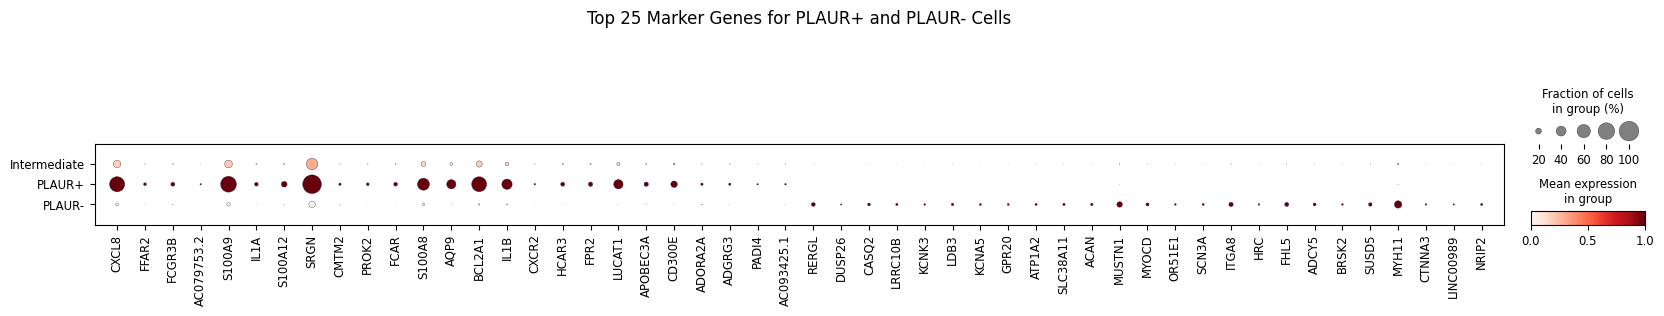

In [35]:
# Create a dot plot for the top 25 marker genes in PLAUR+ and PLAUR- cells, grouped by PLAUR_Status
sc.pl.dotplot(
    epithelial_cells, 
    var_names=top_25_combined_genes, 
    groupby='PLAUR_Status', 
    standard_scale='var',  # Standardize across variables for visual clarity
    title="Top 25 Marker Genes for PLAUR+ and PLAUR- Cells"
)


In [36]:
# Retrieve and print available gene set libraries
libraries = gp.get_library_name()
print(libraries)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

In [37]:
# Define a list of gene set libraries to use for enrichment analysis
gene_sets = [
    'MSigDB_Hallmark_2020',       # Hallmark pathways from MSigDB (2020)
    'KEGG_2021_Human',            # KEGG pathways for humans (2021)
    'WikiPathway_2023_Human',     # WikiPathways for humans (2023)
    'GO_Biological_Process_2023'  # GO biological processes (2023)
]


In [38]:
# Replace placeholders with actual gene lists if not already done
# (assuming you have these lists already defined as we discussed previously)
top_100_upregulated_PLAUR_pos = top_100_upregulated_PLAUR_pos  # List of top 100 genes for PLAUR+
top_100_upregulated_PLAUR_neg = top_100_upregulated_PLAUR_neg  # List of top 100 genes for PLAUR-

# Example of how to check if they are populated correctly
print("Top 100 Upregulated Genes for PLAUR+ Group:", top_100_upregulated_PLAUR_pos)
print("Top 100 Upregulated Genes for PLAUR- Group:", top_100_upregulated_PLAUR_neg)


Top 100 Upregulated Genes for PLAUR+ Group: ['CXCL8', 'FFAR2', 'FCGR3B', 'AC079753.2', 'S100A9', 'IL1A', 'S100A12', 'SRGN', 'CMTM2', 'PROK2', 'FCAR', 'S100A8', 'AQP9', 'BCL2A1', 'IL1B', 'CXCR2', 'HCAR3', 'FPR2', 'LUCAT1', 'APOBEC3A', 'CD300E', 'ADORA2A', 'ADGRG3', 'PADI4', 'AC093425.1', 'LIPN', 'CSF3R', 'HCAR2', 'FCN1', 'AC005280.2', 'SLC11A1', 'IFI30', 'AZIN1-AS1', 'OSM', 'GLT1D1', 'LINC00528', 'EREG', 'NLRP3', 'NEU4', 'SERPINB2', 'SPP1', 'TYROBP', 'FCER1G', 'AL034397.3', 'PHACTR1', 'PLAUR', 'PLEK', 'DNAAF1', 'C5AR1', 'SLC2A3', 'IL1RN', 'IRAK2', 'CLEC4D', 'ATP2B1-AS1', 'AC015912.3', 'SMIM25', 'LAPTM5', 'TREM1', 'CCL3L1', 'LINC00877', 'SLC16A6', 'CCRL2', 'SOD2', 'PPIF', 'TNFRSF1B', 'MEFV', 'LYZ', 'CCL4L2', 'MCEMP1', 'CCL3', 'CLEC4E', 'CFP', 'OLR1', 'NAMPT', 'SEMA6B', 'SLC24A4', 'AC007613.1', 'MIR3945HG', 'VNN2', 'FPR1', 'AL109615.2', 'SIRPB1', 'RBP7', 'ITGAX', 'LCP2', 'CD83', 'PLIN2', 'FGR', 'ALOX5AP', 'LILRA5', 'NCF1', 'LPCAT1', 'SELL', 'ASGR2', 'AC112496.1', 'HIF1A-AS3', 'GPR84', 'MX

In [41]:
import importlib  # Importing the importlib module to reload modules
import utilities  # Importing the custom 'utilities' module

# Reloads the 'utilities' module to reflect any changes made to the module
importlib.reload(utilities)

from utilities import flatten_gene_list, perform_gsea_and_plot

In [40]:
# Flatten the top 100 upregulated gene lists if needed
top_100_upregulated_PLAUR_pos = flatten_gene_list(top_100_upregulated_PLAUR_pos)
top_100_upregulated_PLAUR_neg = flatten_gene_list(top_100_upregulated_PLAUR_neg)

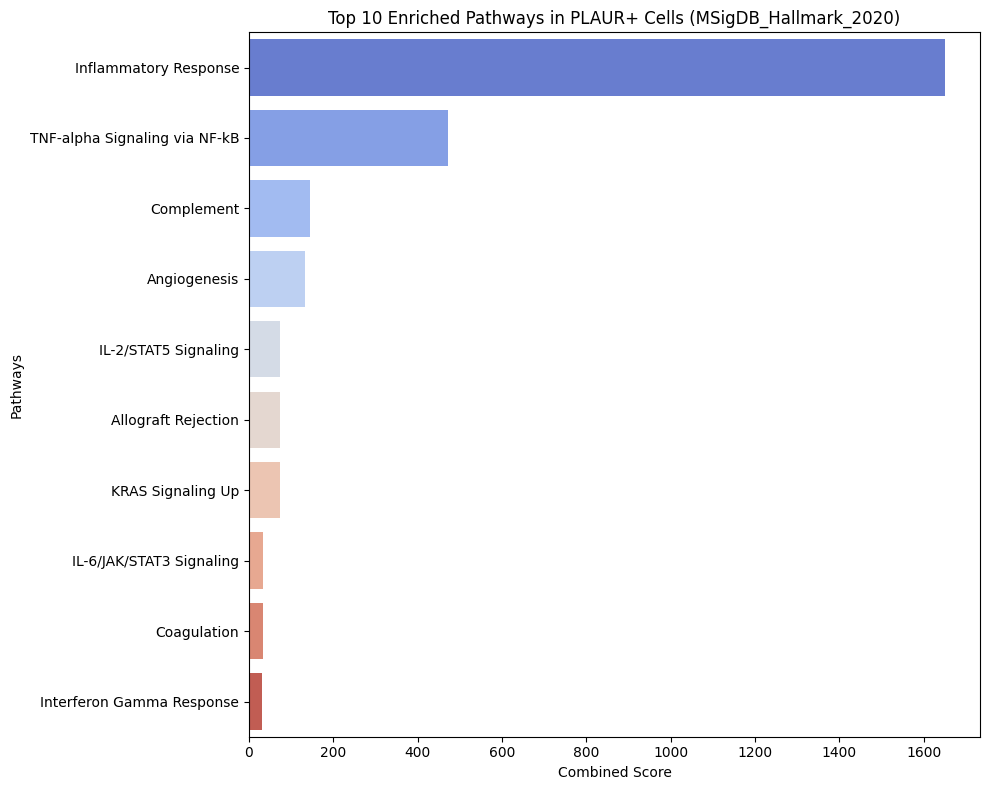

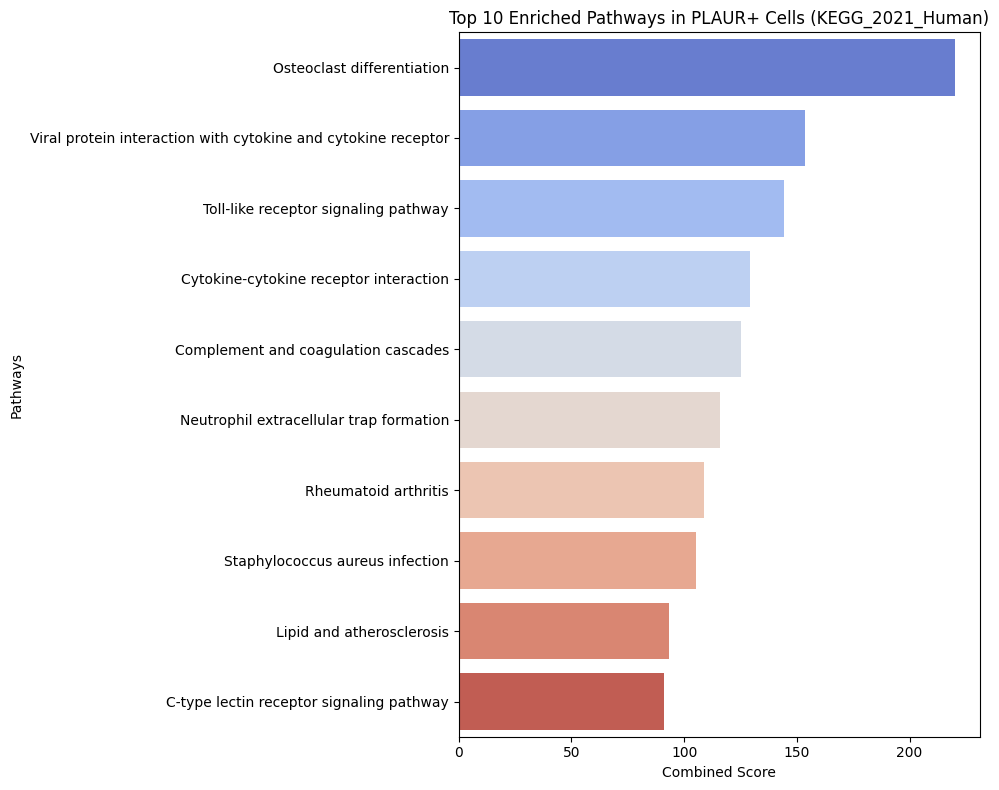

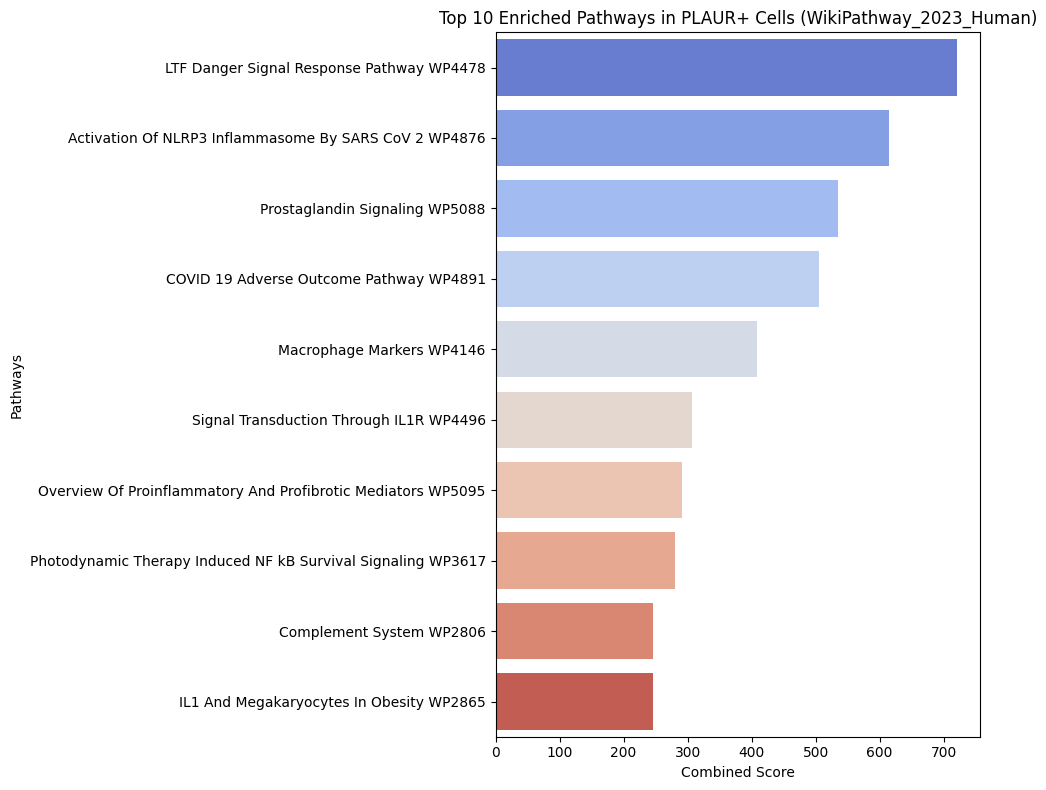

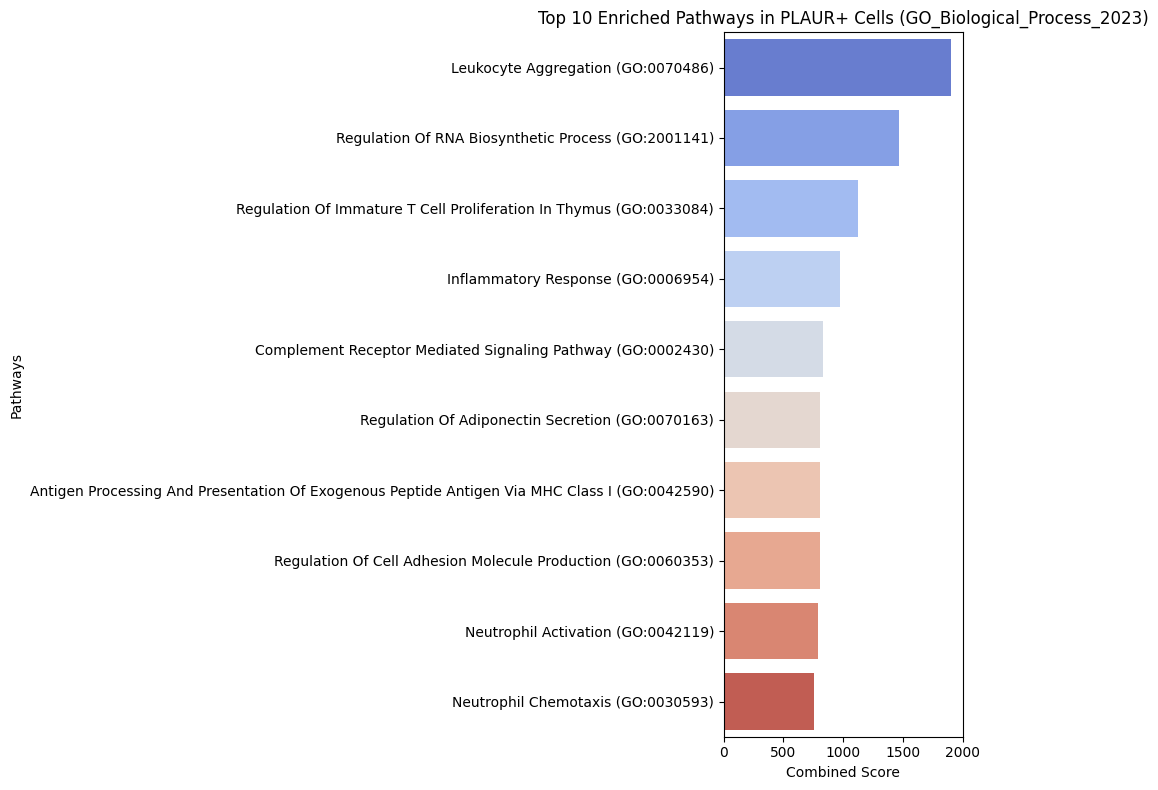

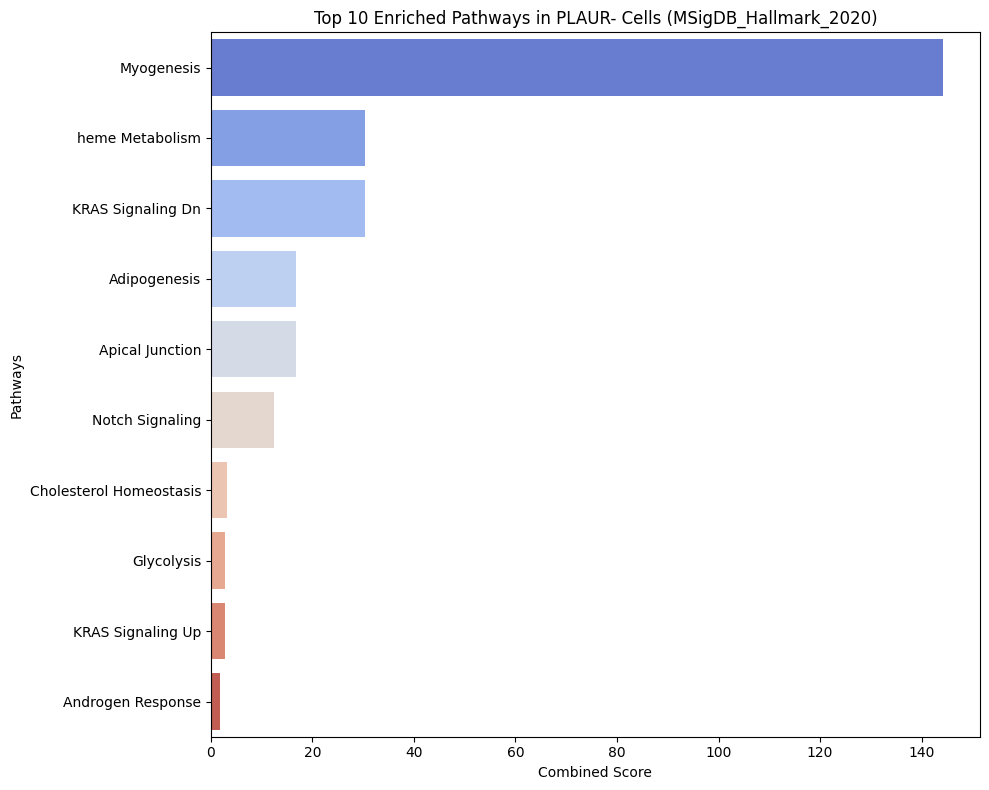

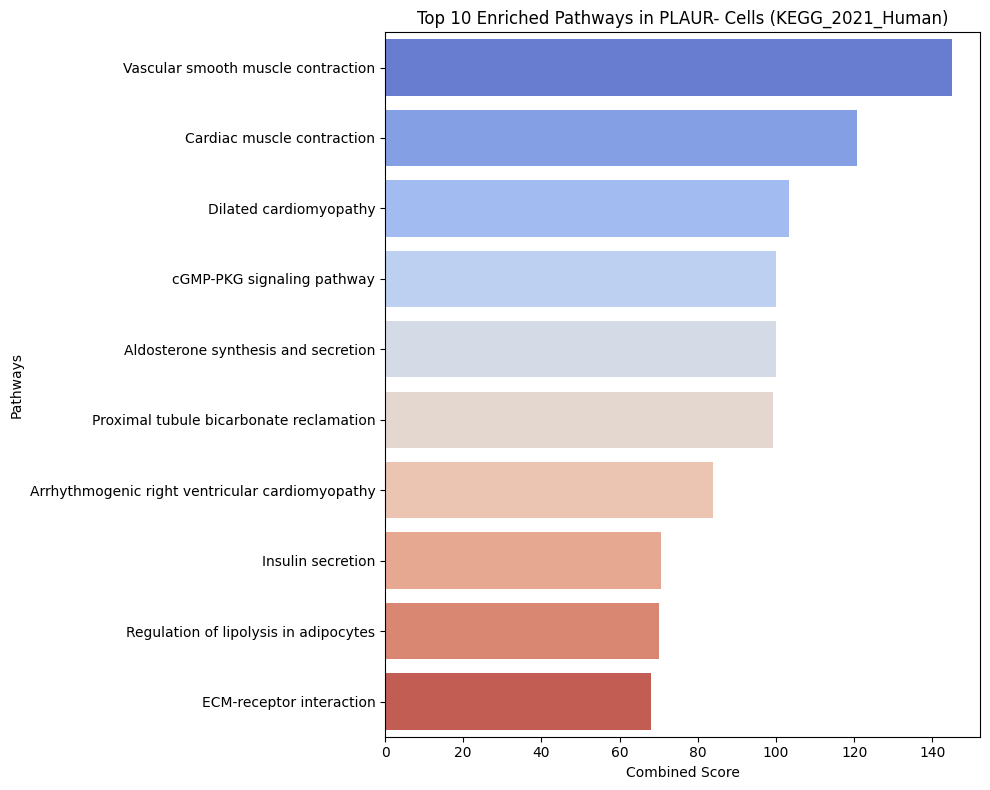

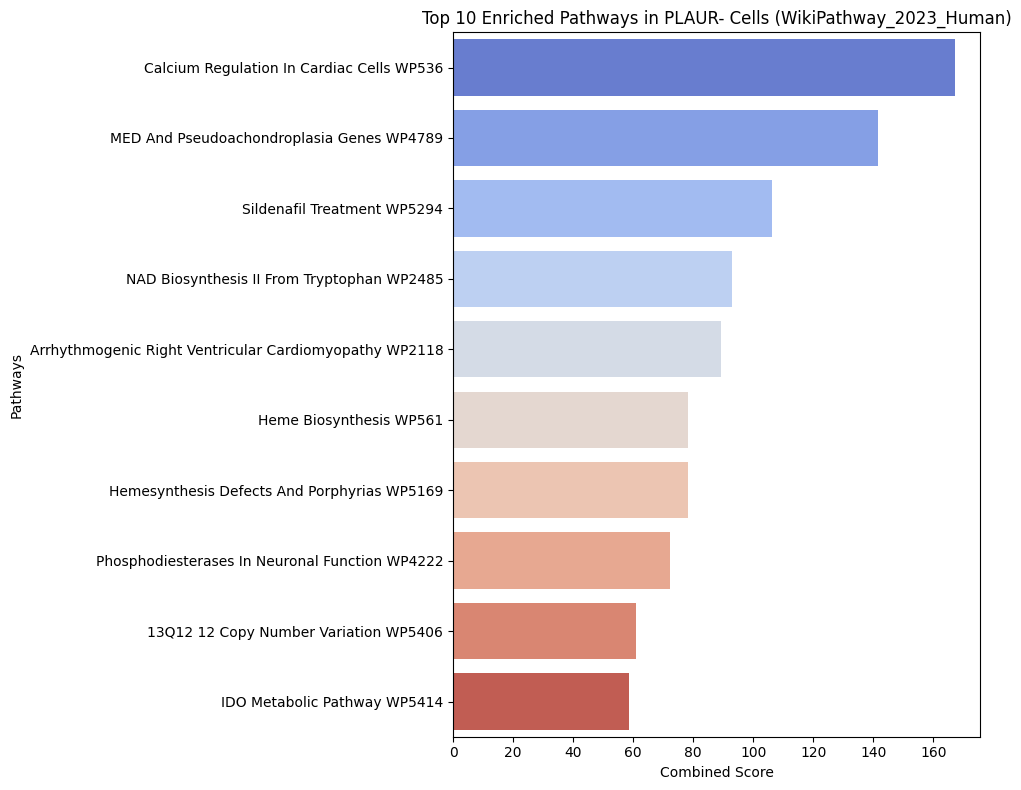

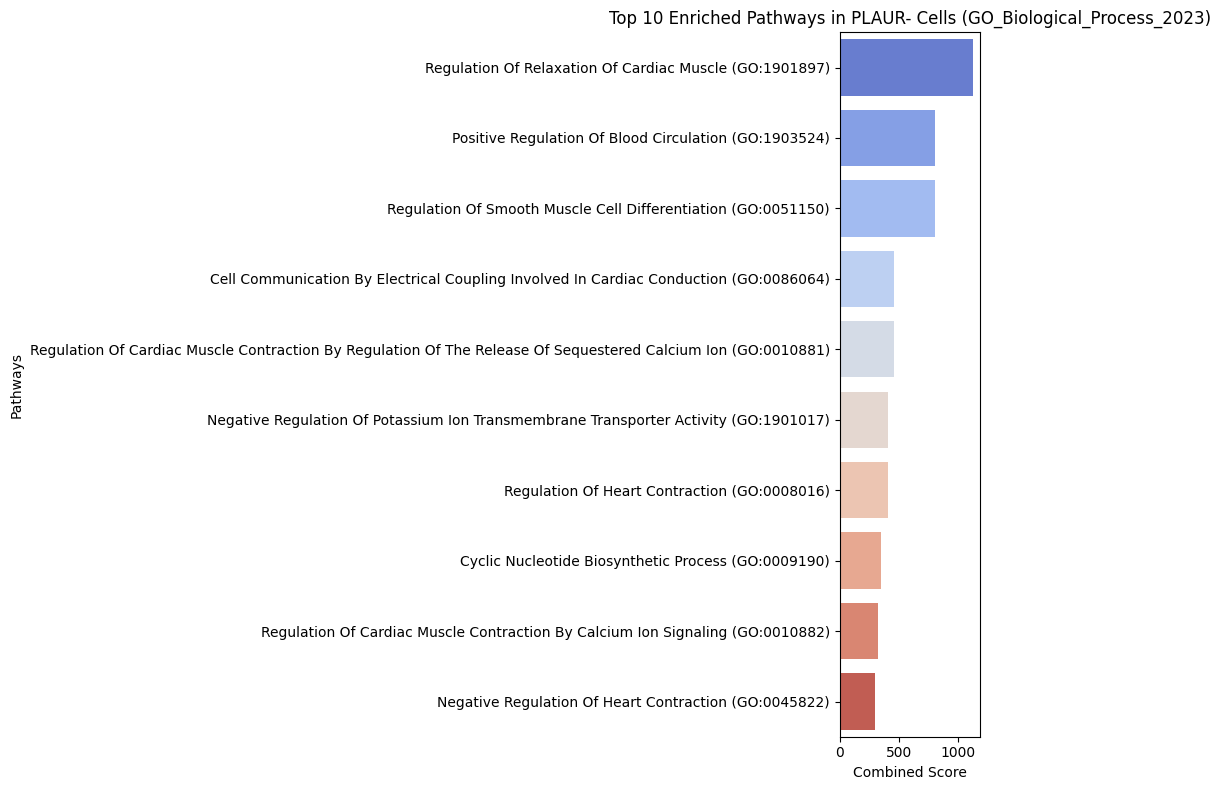

In [42]:
# Step 1: Perform GSEA and plot results for PLAUR+ cells
perform_gsea_and_plot(top_100_upregulated_PLAUR_pos, 'PLAUR+', gene_sets)

# Step 2: Perform GSEA and plot results for PLAUR- cells
perform_gsea_and_plot(top_100_upregulated_PLAUR_neg, 'PLAUR-', gene_sets)

In [43]:
# Step 1: Perform differential expression analysis between PLAUR+ and PLAUR- cells
sc.tl.rank_genes_groups(epithelial_cells, groupby='PLAUR_Status', method='wilcoxon')

# Step 2: Extract the ranked marker genes as a DataFrame
markers3 = sc.get.rank_genes_groups_df(epithelial_cells, None)

# Step 3: Filter markers based on adjusted p-value (< 0.05) and log fold change (> 0.5)
markers3_filtered = markers3[(markers3['pvals_adj'] < 0.05) & (markers3['logfoldchanges'] > 0.5)]


In [44]:
# Select the top 100 markers for PLAUR+ and PLAUR- groups from the filtered markers DataFrame
top_100_PLAUR_pos = markers3_filtered[markers3_filtered['group'] == 'PLAUR+'].head(100)
top_100_PLAUR_neg = markers3_filtered[markers3_filtered['group'] == 'PLAUR-'].head(100)


## Comprehensive Differential Gene Expression Analysis Between PLAUR+ and PLAUR- Cells

In [45]:
epithelial_cells

AnnData object with n_obs × n_vars = 33102 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type', 'cnv_leiden', 'cnv_score', 'PLAUR_Status'
    var: 'n_cells', 'chromosome', 'start', 'end'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [46]:
# Set up the AnnData object for SCVI, specifying count data and covariates for model training
scvi.model.SCVI.setup_anndata(
    epithelial_cells, 
    layer="counts",  # Use the "counts" layer for raw count data
    categorical_covariate_keys=["PLAUR_Status"],  # Categorical covariate: PLAUR status
    continuous_covariate_keys=['pct_counts_mt', 'total_counts']  # Continuous covariates: mitochondrial gene percentage and total counts
)


In [47]:
# Initialize the SCVI model with the prepared AnnData object
model_PLAUR_Status = scvi.model.SCVI(epithelial_cells)


In [48]:
# Train the SCVI model on the epithelial cells dataset
model_PLAUR_Status.train()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/242 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=242` reached.


In [49]:
# Save the trained SCVI model to the specified path for future use
model_PLAUR_Status.save(f'{base_data_path}/model_PLAUR_Status.model_3')
